In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

import numpy as np
import pandas as pd
import pickle

import random

In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [3]:
with open('/Users/ads-14/Desktop/traffic/train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('/Users/ads-14/Desktop/traffic/valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('/Users/ads-14/Desktop/traffic/test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


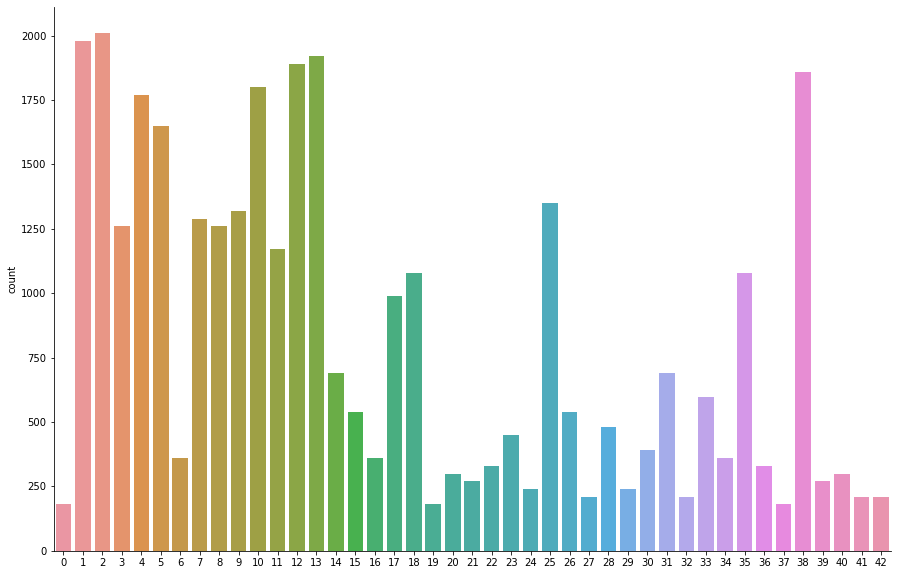

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(x="labels", data=train_data)
sns.despine()

In [5]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 

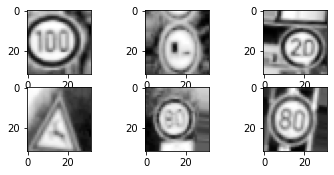

In [6]:
datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

#os.makedirs('/content/drive/My Drive/Traffic_sign_Dataset/images')

for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir='/Users/ads-14/Desktop/traffic/traffic_Data',save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 

In [7]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

    

In [8]:
from kerastuner import RandomSearch
tuner = RandomSearch(build_model, objective='val_accuracy',
                     max_trials = 10, 
                     directory='/Users/ads-14/Desktop/traffic/traffic_Data',
                     project_name="Traffic_Sign")


INFO:tensorflow:Reloading Oracle from existing project /Users/ads-14/Desktop/traffic/traffic_Data/Traffic_Sign/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/ads-14/Desktop/traffic/traffic_Data/Traffic_Sign/tuner0.json


<ipython-input-8-da0707f197f5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [9]:
tuner.search_space_summary()


Search space summary
Default search space size: 12
CONV_1_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': None}
KERNEL_1_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_2_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_2_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
CONV_3_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': None}
KERNEL_3_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 

In [10]:
tuner.search(x_train_final,y_train,epochs=10, validation_data=(x_val_final,y_val))


INFO:tensorflow:Oracle triggered exit


In [11]:
final_model = tuner.get_best_models(num_models=1)[0]

In [12]:
final_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 53)        1378      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 53)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 53)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 84)        40152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 84)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 84)          0

In [13]:
filepath="/Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5"

checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

In [14]:
BATCH_SIZE = 100
EPOCHS = 40
history = final_model.fit(
                            datagen.flow(x_train_final, y_train, batch_size=BATCH_SIZE), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(BATCH_SIZE))), 
                            epochs = EPOCHS, 
                            validation_data =(x_val_final, y_val),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )

Epoch 1/40
348/348 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.7649
Epoch 1: val_accuracy improved from -inf to 0.95510, saving model to /Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 40s 112ms/step - loss: 0.9703 - accuracy: 0.7649 - val_loss: 0.3418 - val_accuracy: 0.9551
Epoch 2/40
348/348 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.8260
Epoch 2: val_accuracy improved from 0.95510 to 0.96281, saving model to /Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 39s 113ms/step - loss: 0.7541 - accuracy: 0.8260 - val_loss: 0.3217 - val_accuracy: 0.9628
Epoch 3/40
348/348 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.8516
Epoch 3: val_accuracy improved from 0.96281 to 0.96463, saving model to /Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] -

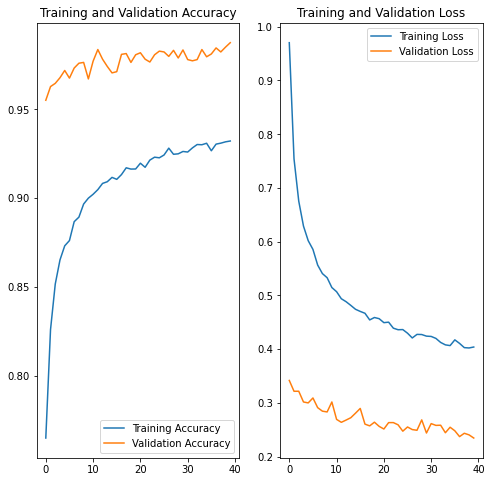

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
final_model.load_weights("/Users/ads-14/Desktop/traffic/traffic_Data/Traffic_Sign_Classifier_CNN.hdf5")
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
Pred_conv = final_model.evaluate(x_test_final, y_test, verbose=0)
print("Results on the test data")
print(" ")
print("%s- %.2f" % (final_model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (final_model.metrics_names[1], Pred_conv[1]))

Results on the test data
 
loss- 0.32
accuracy- 0.96


In [18]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

Predicted sign: [[7.86717109e-08 3.51264025e-04 3.54046165e-07 8.53365577e-07
  1.60749991e-08 6.98318399e-05 9.99531269e-01 5.76806443e-08
  6.27131624e-10 2.72111934e-12 1.26803967e-09 9.90711300e-08
  7.48805888e-08 1.94550798e-09 9.23183752e-12 1.44612003e-10
  5.70813841e-10 5.66803061e-13 4.26342694e-08 2.15234428e-12
  5.36115685e-09 7.01477498e-09 9.15213109e-13 4.17068630e-10
  3.04695580e-09 3.01332250e-07 9.72387587e-11 1.11971946e-10
  1.41211643e-07 3.21968336e-08 1.55515423e-07 5.58565425e-08
  1.25235038e-05 1.79009120e-07 1.83956305e-11 6.98076319e-10
  4.02839040e-10 9.45186063e-09 6.42934651e-07 1.60436102e-07
  1.11910836e-07 1.09397895e-07 3.17581398e-05]]
---------------------------------------------------------------------------
Predicted Sign[0]


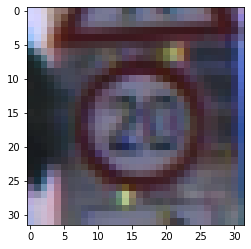

In [19]:

plt.imshow(x_test[990]) 
print("Predicted sign: "+ str( 
        final_model.predict(x_test_final[1700].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(np.argmax(final_model.predict(x_test_final[990].reshape(1, 32, 32, 1)), axis=-1)))

In [20]:
final_model.save('/Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5')


In [22]:
import tensorflow as tf

In [23]:
loaded_model = tf.keras.models.load_model('/Users/ads-14/Desktop/traffic/Traffic_Sign_Classifier_CNN.hdf5')

loaded_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 53)        1378      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 53)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 53)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 84)        40152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 84)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 84)          0

Predicted sign: [[4.4353300e-08 3.4123799e-03 5.5393623e-03 3.6645189e-03 3.1608552e-06
  9.5842487e-01 6.4415744e-06 2.8938198e-02 4.1437861e-06 2.2682199e-08
  3.2805876e-06 6.6765913e-09 3.3003477e-08 6.6496488e-09 4.7593085e-10
  2.6220647e-07 1.6705526e-07 1.7436973e-09 8.3147196e-12 1.6443015e-11
  7.7728884e-10 6.7574319e-09 6.6667246e-14 7.3724957e-11 1.0022269e-09
  8.4455101e-09 4.5030798e-12 2.6685004e-12 9.7827668e-10 1.0406245e-07
  1.9170193e-07 2.7406429e-07 5.6427085e-09 1.7755589e-07 2.8192698e-10
  8.2504839e-09 2.4128971e-11 4.1671747e-10 1.5770979e-08 3.3326510e-09
  1.0348277e-06 1.6609564e-12 1.2296292e-06]]
---------------------------------------------------------------------------
Predicted Signtf.Tensor(
[[4.4353300e-08 3.4123799e-03 5.5393623e-03 3.6645189e-03 3.1608552e-06
  9.5842487e-01 6.4415744e-06 2.8938198e-02 4.1437861e-06 2.2682199e-08
  3.2805876e-06 6.6765913e-09 3.3003477e-08 6.6496488e-09 4.7593085e-10
  2.6220647e-07 1.6705526e-07 1.7436973e-09 8

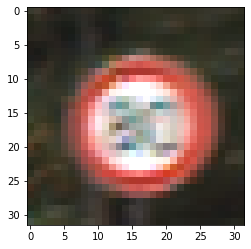

In [ ]:
plt.imshow(x_test[1832]) 
print("Predicted sign: "+ str( 
        loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(loaded_model(x_test_final[1832].reshape(1, 32, 32, 1))))

In [ ]:
import tensorflow as tf

In [ ]:
loaded_model = tf.keras.models.load_model('/Users/ads-14/Desktop/traffic/traffic_Data')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 53)        1378      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 53)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 53)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 84)        40152     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 84)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 84)          0

In [24]:
from tensorflow.keras.models import load_model

import cv2

import numpy as np

final_model = load_model('/Users/ads-14/Desktop/traffic/traffic_Data')

img = cv2.imread('/Users/ads-14/Desktop/traffic/traffic_Data/img_5967_3892.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = np.argmax(final_model.predict(img))

print(classes)


3
